# Emperor Penguin accessibility per grid cell - FUTURE
- Calculate how many Emperor penguins can reach each CESM grid cells and save as netcdf file.
- Notebook by Alice DuVivier (NCAR)
- October 2024

## Steps for Colonies

1) Load distance from colonies to each grid cell. **This file is the same as for "present day" colonies, so we did not need to go through distance calculation again.**

2) Load the future Emperor penguin population projections by year (Emperor_colony_future_projections_median_CMR.csv) from Stephanie Jenouvrier (WHOI). This uses the projection method she has previously used (see Jenouverier et al. 2019, https://doi.org/10.1111/gcb.14864). These projections have been updated to use CESM2-LE climate data and span the period 1900-2100 (201 years). Here, we use only the median projected population.

3) Assume that # individuals who can reach a grid point drops off exponentially. $y = y_0*e^{-Ax}$ where y is the # individuals, $y_0$ is the colony population, and x is the distance.
- For EP we are using the **average foraging distance** - 428km (need citation from Stef).
- Since this is an average foraging distance, we assume that 1/2 of all individuals in a colony could reach that distance ($y = 0.5y_0$ @ x = avg_dist). Thus, the decay rate will be $A = -\frac{1}{x}ln(0.5)$. This is the same rate for all colonies.
- Note that we're assuming a radial distance for foraging but this was probably not a linear distance traveled

3) Sum up for each grid cell how many individuals can potentially access that cell from all colonies within foraging range.
- Cells that are within range of multiple colonies will be most important for that species.

In [1]:
import utils
import pandas as pd
import xarray as xr
import numpy as np
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

In [2]:
# define exponential decline function for how many individuals can access a grid cell
from math import log, exp
def decline(pop_tot, dist_max):
    rate = -log(0.5)/dist_max
    return rate

## Read in Emperor colony data

In [3]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'

### Colony location data

In [4]:
# load Emperor Penguin distances
file_in = 'CESM_grid_Emperor_colony_present_day.nc'
ds_ep = xr.open_dataset(path_in+file_in, decode_times=True)

In [5]:
ds_ep = ds_ep.rename({'index':'colonies'})

In [6]:
# get data we'll need for this
dist_colony = ds_ep.colony_distance

In [7]:
# get dimensions of the grid we need to iterate over
xlen = len(ds_ep.nlon)
ylen = len(ds_ep.nlat)
clen = len(ds_ep.colonies)
print(xlen,ylen,clen)

320 36 66


In [8]:
# save list of colony IDs
colonies_present = ds_ep.site_id

### Read in Emperor colony population projections

In [9]:
# these population projections are for years 1900-2100
years = np.arange(1900,2101,1)
tlen = len(years)
print(tlen)

201


In [10]:
# load future Emperor Penguin population projections
file_in = 'Emperor_colony_future_projections_median_CMR.csv'
data = pd.read_csv(path_in + file_in)

In [11]:
data

,SNOW,JASN,DOLL,SMTH,GOUL,LUIT,HALY,DAWS,STCB,DRES,...,BEAR,BSON,NOVI,PFRO,BRYA,SMYL,VERD,ROTS,DION,DARL
0,3787.200,5561.6,9887.4,3424.70,4438.100,5251.900,12448.000,5385.500,6916.2000,7923.7000,...,1508.700,1497.000,1557.900,407.270,1180.700,1668.000,479.910,1530.700,447.630,408.000
1,3473.200,9186.2,9753.3,3467.50,4200.100,6500.900,12984.000,5773.400,7588.0000,7817.9000,...,1379.900,1451.500,1419.400,666.520,1161.300,1543.500,773.160,918.070,461.680,354.010
2,2895.900,10699.0,9572.0,3472.20,3887.200,6823.000,12589.000,5020.600,6852.7000,6297.7000,...,1047.100,1168.400,1032.800,691.330,939.260,1075.800,759.470,691.710,306.550,260.050
3,2452.300,11843.0,9397.9,3515.80,3608.600,7181.900,12239.000,4634.700,6432.3000,5648.4000,...,914.990,989.050,912.080,725.670,869.880,977.200,785.000,617.270,261.330,212.110
4,2126.100,12699.0,9300.9,3506.10,3460.300,7370.400,12045.000,4505.000,6427.2000,5401.2000,...,828.240,939.070,857.410,743.780,864.150,958.630,791.470,617.490,243.000,210.320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,36.406,2112.8,5476.0,1177.80,128.570,34.413,27.461,28.782,22.5750,11.8540,...,47.374,46.015,41.024,38.824,38.502,40.874,36.415,34.453,20.301,18.949
197,35.144,2065.3,5369.4,973.65,92.625,30.361,22.423,23.605,17.8470,9.2708,...,42.972,41.904,37.345,34.650,33.760,36.175,32.570,30.722,18.692,15.433
198,36.473,1809.2,5089.8,904.18,71.048,23.696,19.254,19.939,14.1610,7.3993,...,45.310,43.717,38.995,36.778,36.068,38.808,34.855,33.879,21.752,19.057
199,32.297,1753.5,4657.8,797.08,44.398,20.674,15.084,15.647,11.4960,5.6889,...,41.729,40.317,36.196,33.632,33.366,35.553,32.313,31.683,19.353,15.033


In [12]:
# save list of colony IDs
colonies_future = list(data)

In [13]:
# check that colonies are the same
print('Present day colony IDs')
print(colonies_present)
print('Future colony IDs')
print(colonies_future)

Present day colony IDs
<xarray.DataArray 'site_id' (colonies: 66)>
array(['SNOW', 'JASN', 'DOLL', 'SMTH', 'GOUL', 'LUIT', 'HALY', 'DAWS', 'STCB',
       'DRES', 'RIIS', 'ATKA', 'SANA', 'ASTD', 'LAZA', 'RAGN', 'GUNN', 'UMBE',
       'CBYW', 'AMUN', 'KLOA', 'FOLD', 'TAYG', 'AUST', 'DARN', 'AMAN', 'WISH',
       'BBAY', 'KARE', 'BURT', 'HASW', 'SHAC', 'BOWM', 'PSON', 'POIN', 'SABC',
       'PBAY', 'DIBB', 'PGEO', 'MERB', 'MERT', 'NINN', 'DBAY', 'ROGE', 'COUL',
       'WASH', 'YULE', 'FRAN', 'BEAN', 'CROZ', 'CBEK', 'RUPE', 'CRUZ', 'LEDD',
       'THUR', 'GATE', 'BEAR', 'BSON', 'NOVI', 'PFRO', 'BRYA', 'SMYL', 'VERD',
       'ROTS', 'DION', 'DARL'], dtype=object)
Coordinates:
  * colonies  (colonies) int64 0 1 2 3 4 5 6 7 8 ... 57 58 59 60 61 62 63 64 65
Future colony IDs
['SNOW', 'JASN', 'DOLL', 'SMTH', 'GOUL', 'LUIT', 'HALY', 'DAWS', 'STCB', 'DRES', 'RIIS', 'ATKA', 'SANA', 'ASTD', 'LAZA', 'RAGN', 'GUNN', 'UMBE', 'CBYW', 'AMUN', 'KLOA', 'FOLD', 'TAYG', 'AUST', 'DARN', 'AMAN', 'WISH', 'BBAY'

In [14]:
# convert future data to xarray
populations = xr.DataArray(data,dims=('year','colonies'))

In [15]:
# assign metadata
populations['year'] = years
populations['colonies'] = ds_ep.colonies

In [16]:
populations

<xarray.DataArray (year: 201, colonies: 66)>
array([[ 3787.2  ,  5561.6  ,  9887.4  , ...,  1530.7  ,   447.63 ,
          408.   ],
       [ 3473.2  ,  9186.2  ,  9753.3  , ...,   918.07 ,   461.68 ,
          354.01 ],
       [ 2895.9  , 10699.   ,  9572.   , ...,   691.71 ,   306.55 ,
          260.05 ],
       ...,
       [   36.473,  1809.2  ,  5089.8  , ...,    33.879,    21.752,
           19.057],
       [   32.297,  1753.5  ,  4657.8  , ...,    31.683,    19.353,
           15.033],
       [   30.582,  1608.1  ,  4462.9  , ...,    31.05 ,    19.071,
           16.647]])
Coordinates:
  * year      (year) int64 1900 1901 1902 1903 1904 ... 2096 2097 2098 2099 2100
  * colonies  (colonies) int64 0 1 2 3 4 5 6 7 8 ... 57 58 59 60 61 62 63 64 65

## Read in Grid data

In [17]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [18]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [19]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [20]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

## Calculate how many penguins can reach each grid cell

In [21]:
# set EP average foraging distance (km)
rr = 428

In [23]:
# loop through colonies to calculate individuals for that colony for each year
individuals = np.zeros([clen,tlen,ylen,xlen])

for col in np.arange(0,clen,1):
    dist = dist_colony.isel(colonies=col)
    for yy in years:
        if yy == 1900:
            yind = 0
        else:
            yind = yind+1
        # grab population for this colony and this year            
        pop = populations.isel(colonies=col).sel(year=yy)
        # get decline rate for this colony
        rate = decline(pop,rr)
        # calculate how many individuals from the colony can reach each point
        individuals[col,yind,:,:] = pop * np.exp(-rate*dist)

# convert to xarray
individuals = xr.DataArray(individuals,dims=('colonies','time','nlat','nlon'))
individuals.attrs['units'] = 'number of emperor penguins'
individuals['colonies'] = ds_ep.colonies
individuals['time'] = years
individuals['nlat'] = ds_ep.nlat
individuals['nlon'] = ds_ep.nlon

In [24]:
# omit land points
individuals_keep = individuals.where(ds_grid.REGION_MASK == 1)

In [25]:
# sum over all colonies
total_ep = individuals_keep.sum(dim='colonies')

# omit land points
total_ep = total_ep.where(ds_grid.REGION_MASK == 1)

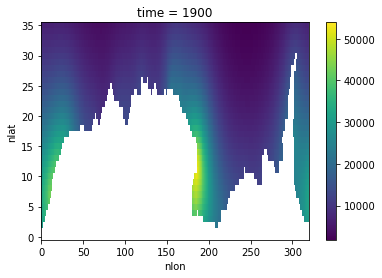

In [27]:
total_ep.isel(time=0).plot()

## Put together into one dataset

- Netcdf with variable dimension: (nlat x nlon)
- Keep the total penguins that can access a cell in present day

In [28]:
ds_out = xr.Dataset()

ds_out['total_penguins'] = total_ep

ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'Future number of Emperor penguins who can access each grid point by year.'

ds_out

<xarray.Dataset>
Dimensions:         (time: 201, nlat: 36, nlon: 320)
Coordinates:
  * time            (time) int64 1900 1901 1902 1903 ... 2097 2098 2099 2100
  * nlat            (nlat) int64 0 1 2 3 4 5 6 7 8 ... 28 29 30 31 32 33 34 35
  * nlon            (nlon) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
    ULONG           (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    ULAT            (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLONG           (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT            (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Data variables:
    total_penguins  (time, nlat, nlon) float64 dask.array<chunksize=(201, 36, 320), meta=np.ndarray>
Attributes:
    author:          Alice DuVivier
    date_processed:  2024-10-09
    contents:        Future number of Emperor penguins who can access each gr...

In [29]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")

Dimensions:
	time: (201,)
	nlat: (36,)
	nlon: (320,)
Coordinates:
	time:
		[1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913
 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927
 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941
 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955
 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969
 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025
 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039
 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053
 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067
 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081
 2

## Export and Save

In [30]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")


The dataset is approximately 0.02 GB.


In [31]:
path_out = path_in
file_out = 'CESM_grid_Emperor_individual_access_future.nc'
fout = path_out + file_out

In [32]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)